In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TextStreamer
import torch
from utils import WordHighlightingStreamerFactory
import logging
import sys

device = 'cuda'

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    stream=sys.stdout,
)

model_name = "Qwen/Qwen3-32B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16).to(device)
streamer_factory = WordHighlightingStreamerFactory(tokenizer, 'wait', skip_prompt=False)


Loading checkpoint shards:   0%|          | 0/17 [00:00<?, ?it/s]

In [5]:
from gpqa_dataset import GPQADataset
from pprint import pprint

dataset = GPQADataset(config_name="gpqa_diamond", split="train")



print(len(dataset))
pprint(dataset[0])

Using the latest cached version of the dataset since Idavidrein/gpqa couldn't be found on the Hugging Face Hub


2025-08-01 12:50:24,716 - WARNING - datasets.load - Using the latest cached version of the dataset since Idavidrein/gpqa couldn't be found on the Hugging Face Hub


Found the latest cached dataset configuration 'gpqa_diamond' at /home/tikhonov/.cache/huggingface/datasets/Idavidrein___gpqa/gpqa_diamond/0.0.0/90b8e5be2b1d3d2dbfe016cdab47981150600c4a (last modified on Tue Jul 29 18:26:56 2025).


2025-08-01 12:50:24,718 - WARNING - datasets.packaged_modules.cache.cache - Found the latest cached dataset configuration 'gpqa_diamond' at /home/tikhonov/.cache/huggingface/datasets/Idavidrein___gpqa/gpqa_diamond/0.0.0/90b8e5be2b1d3d2dbfe016cdab47981150600c4a (last modified on Tue Jul 29 18:26:56 2025).
198
{'answer_index': 2,
 'answer_letter': 'C',
 'answer_text': '10^-4 eV',
 'choices': ['10^-9 eV', '10^-8 eV', '10^-4 eV', '10^-11 eV'],
 'prompt': 'Two quantum states with energies E1 and E2 have a lifetime of '
           '10^-9 sec and 10^-8 sec, respectively. We want to clearly '
           'distinguish these two energy levels. Which one of the following '
           'options could be their energy difference so that they can be '
           'clearly resolved?\n'
           '\n'
           '\n'
           'A) 10^-9 eV\n'
           'B) 10^-8 eV\n'
           'C) 10^-4 eV\n'
           'D) 10^-11 eV',
 'question': 'Two quantum states with energies E1 and E2 have a lifetime of '
    

In [ ]:
import sqlite3

conn = sqlite3.connect("reasoning_traces.sqlite")
cursor = conn.cursor()


def get_reasoning_trace(question):
    sql_query = f"""
        SELECT question_id, full_prompt_text, correct_answer_letter, extracted_answer
        FROM reasoning_traces_qpqa
        WHERE question_text LIKE ? AND model_path = ?
        LIMIT 1
    """
    
    search_pattern = f'%{question}%'
    model_name = 'Qwen/Qwen3-32B'

    row = cursor.execute(sql_query, (search_pattern, model_name)).fetchone()

    return row[1].split('<think>')[1].split('</think>')[0].strip()


In [ ]:
def simple_parse_answer(output, use_boxed=False):
    tokens = tokenizer.convert_ids_to_tokens(output)
    assert tokens[-1] == '<|im_end|>', f'Got {tokens[-1]} instead of <|im_end|>'
    
    if use_boxed:

        assert tokens[-2] == '}', f'Got {tokens[-2]} instead of }}'
        assert tokens[-3] in 'ABCD', f'Got {tokens[-3]} instead of A, B, C or D'
        return tokens[-3]
    else:
        assert tokens[-2] in 'ABCD', f'Got {tokens[-2]} instead of A, B, C or D'
        return tokens[-2]

def get_question_prompt(question, thinking_content='\n\n'):
    messages = [
        {"role": "system", "content": "Reason step-by-step, and put the letter of the correct option within \\boxed{}."},
        {"role": "user", "content": question},
        {"role": "assistant", "content": f"<think>{thinking_content}</think>\n\n\\boxed{{"},
    ]

    
    # {"role": "assistant", "content": "<think>\nI think I know the answer, now I'm ready to respond.\n</think>"},

    prompt = tokenizer.apply_chat_template(messages, tokenize=False, continue_final_message=True, enable_thinking=False, add_generation_prompt=False, )
    # prompt = prompt.replace(
    #     '<think>\n\n</think>\n\n<think>', '<think>'
    # )

    return prompt



In [ ]:
d = dataset[0]
reasoning_trace_raw = get_reasoning_trace(d['question'])




normalized_text = reasoning_trace_raw.replace('.\n', '. ').strip()
sentences = normalized_text.split('. ')
reasoning_trace = '. '.join(sentences[:10])

# reasoning_trace = reasoning_trace_raw.split('. ')[0].split('.\n')[0].strip()

reasoning_trace = f"\n{reasoning_trace}.\nConsidering the limited time by the user, I have to give the solution based on the thinking directly now.\n"

question_prompt = get_question_prompt(d['prompt'], reasoning_trace)
inputs = tokenizer.encode(question_prompt, return_tensors="pt").to(device)
output = model.generate(inputs, max_new_tokens=3, temperature=0.6, streamer=streamer_factory())

print(tokenizer.decode(output[0], skip_special_tokens=False))
print(simple_parse_answer(output[0], use_boxed=True))


<|im_start|>system
Reason step-by-step, and put the letter of the correct option within \boxed{}.<|im_end|>
<|im_start|>user
Two quantum states with energies E1 and E2 have a lifetime of 10^-9 sec and 10^-8 sec, respectively. We want to clearly distinguish these two energy levels. Which one of the following options could be their energy difference so that they can be clearly resolved?


A) 10^-9 eV
B) 10^-8 eV
C) 10^-4 eV
D) 10^-11 eV<|im_end|>
<|im_start|>assistant
<think>
Okay, so I've got this question about two quantum states with different energies and lifetimes. The question is asking what energy difference between them would allow us to clearly distinguish or resolve the two energy levels. The options are A) 10^-9 eV, B) 10^-8 eV, C) 10^-4 eV, D) 10^-11 eV. 

Hmm, I remember something about the uncertainty principle related to energy and time. Like, the Heisenberg uncertainty principle isn't just for position and momentum, but also has an energy-time version. The formula might b

(array([76., 32., 22., 30., 22., 11.,  3.,  0.,  0.,  2.]),
 array([  12. ,  112.8,  213.6,  314.4,  415.2,  516. ,  616.8,  717.6,
         818.4,  919.2, 1020. ]),
 <BarContainer object of 10 artists>)

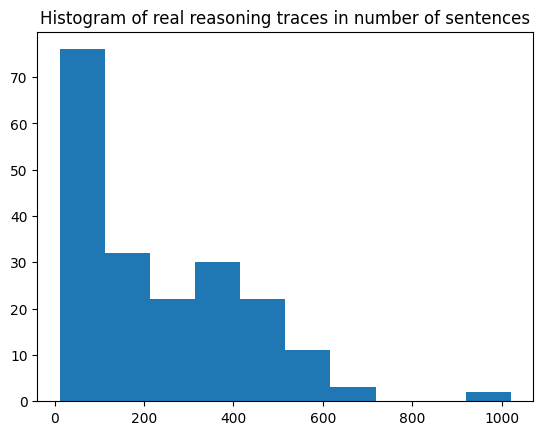

In [ ]:
lengths = []

for d in dataset:
    try:
        reasoning_trace_raw = get_reasoning_trace(d['question'])

    except TypeError:
        print(f'Warning: skipping question')

    normalized_text = reasoning_trace_raw.replace('.\n', '. ').strip()
    sentences = normalized_text.split('. ')

    lengths.append(len(sentences))

plt.title('Histogram of real reasoning traces in number of sentences')
plt.hist(lengths)


Okay, so I've got this question about two quantum states with different energies and lifetimes.
Okay, let me try to figure this out.
Okay, so I need to find the expectation value of the operator 10σ_z + 5σ_x for a spin-half particle in the state 0.5|↑⟩ + sqrt(3)/2|↓⟩.
Okay, so I need to figure out which of Maxwell's equations would be different in a parallel universe where magnets can have isolated North or South poles.
Okay, let's try to figure out this problem.
Okay, let's see.
Okay, let's see.
Okay, let's see.
Okay, let me try to figure out which molecule has C3h symmetry.
Okay, so I need to figure out which of these exoplanet options has the highest density.
Okay, let's tackle this question about SARS-CoV-2 molecular biology.
Okay, so I need to find the kinetic energy of the product particles when a stationary pion (π+) decays into a muon (μ+) and a neutrino (ν).
Okay, let's try to figure this out.
Okay, let's tackle this ChIP-seq question.
Okay, let's see.
Okay, let's tackle this 

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

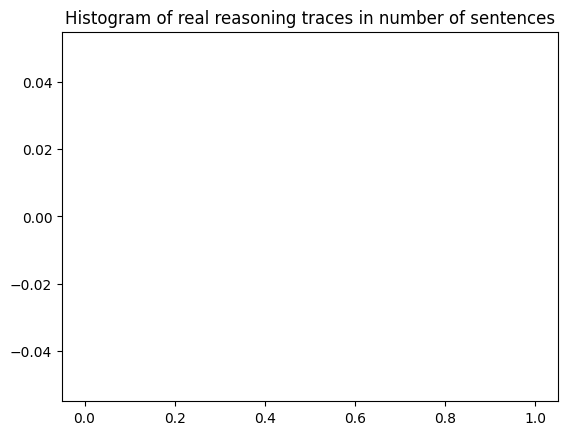

In [179]:
lengths = []
first_sentences = []

for d in dataset:
    try:

        reasoning_trace_raw = get_reasoning_trace(d['question'])
    except TypeError:
        print(f'Warning: skipping question')

    normalized_text = reasoning_trace_raw.replace('.\n', '. ').strip()
    sentences = normalized_text.split('. ')

    print(sentences[0]+'.')
    first_sentences.append(sentences[0]+'.')

plt.title('Histogram of real reasoning traces in number of sentences')
plt.hist(lengths)


In [183]:
from collections import Counter

Counter([x.split(' ')[0] for x in first_sentences])

Counter({'Okay,': 196, 'Okay.': 2})

In [184]:
from collections import Counter

Counter([x for x in first_sentences])

Counter({"Okay, let's see.": 65,
         "Okay, let's try to figure out this problem.": 14,
         "Okay, let's try to figure this out.": 14,
         "Okay, let's tackle this problem step by step.": 7,
         "Okay, let's try to figure this out step by step.": 7,
         'Okay, let me try to work through this problem step by step.': 5,
         "Okay, let's tackle this problem.": 5,
         'Okay, let me try to figure this out.': 4,
         "Okay, let's try to figure out this problem step by step.": 3,
         "Okay, so I need to figure out the factor by which the ratio of neutral Ti atoms in two energy levels changes when the star has spots compared to when it doesn't.": 2,
         'Okay.': 2,
         "Okay, let's try to figure out which of these statements is correct.": 2,
         "Okay, so I've got this question about two quantum states with different energies and lifetimes.": 1,
         'Okay, so I need to find the expectation value of the operator 10σ_z + 5σ_x for a 

In [185]:
d['question']

'We have a solution containing Co(II) ions and thiocyanate, where the total cobalt concentration is c(Co) = 10^-2 M and the [SCN-] concentration is 0.1 M. The stability constants of the cobalt(II) thiocyanato complexes are β1=9, β2=40, β3=63 and β4=16. What will be the percentage of the blue dithiocyanato cobalt(II) complexes among all cobalt containing species in the solution? '

In [170]:
import numpy as np
np.mean(lengths)

np.float64(238.3080808080808)

  0%|          | 0/10 [00:00<?, ?it/s]


==================== Starting Run 1/10 ====================


Run 1:   0%|          | 0/198 [00:00<?, ?it/s]

Run 1 finished. Accuracy: 0.4192

==================== Starting Run 2/10 ====================


Run 2:   0%|          | 0/198 [00:00<?, ?it/s]

Run 2 finished. Accuracy: 0.4141

==================== Starting Run 3/10 ====================


Run 3:   0%|          | 0/198 [00:00<?, ?it/s]

Run 3 finished. Accuracy: 0.4394

==================== Starting Run 4/10 ====================


Run 4:   0%|          | 0/198 [00:00<?, ?it/s]

Run 4 finished. Accuracy: 0.4192

==================== Starting Run 5/10 ====================


Run 5:   0%|          | 0/198 [00:00<?, ?it/s]

Run 5 finished. Accuracy: 0.4242

==================== Starting Run 6/10 ====================


Run 6:   0%|          | 0/198 [00:00<?, ?it/s]

Run 6 finished. Accuracy: 0.4242

==================== Starting Run 7/10 ====================


Run 7:   0%|          | 0/198 [00:00<?, ?it/s]

Run 7 finished. Accuracy: 0.4394

==================== Starting Run 8/10 ====================


Run 8:   0%|          | 0/198 [00:00<?, ?it/s]

Run 8 finished. Accuracy: 0.4192

==================== Starting Run 9/10 ====================


Run 9:   0%|          | 0/198 [00:00<?, ?it/s]

Run 9 finished. Accuracy: 0.4394

==================== Starting Run 10/10 ====================


Run 10:   0%|          | 0/198 [00:00<?, ?it/s]

Run 10 finished. Accuracy: 0.4141

             All runs completed. Final Report:

Total runs: 10
Mean Accuracy: 0.4253 ± 0.0098
Mean Accuracy: 42.53% ± 0.98%


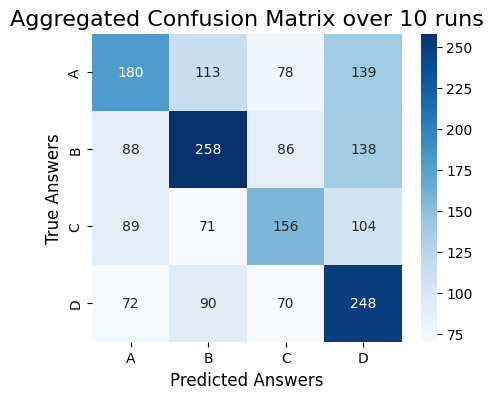

In [173]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tqdm.auto import tqdm

# --- 1. Settings and Initialization ---
num_runs = 10  # Number of full runs over the dataset
accuracies_over_runs = []

# Pre-determine all possible labels for stability
# This ensures that the confusion matrices always have the same size
possible_labels = sorted(list(set(d['answer_letter'] for d in dataset)))
aggregated_cm = np.zeros((len(possible_labels), len(possible_labels)), dtype=int)

# --- 2. Main Experiment Loop ---
for run_num in tqdm(range(1, num_runs + 1)):
    print(f"\n{'='*20} Starting Run {run_num}/{num_runs} {'='*20}")
    
    # Lists to collect results for the CURRENT run
    all_predictions = []
    all_ground_truths = []

    for i, d in tqdm(enumerate(dataset), total=len(dataset), desc=f"Run {run_num}"):

        try:
            reasoning_trace_raw = get_reasoning_trace(d['question'])
        except TypeError:
            print(f'Warning: skipping question {i} in run {run_num} due to missing reasoning trace in db')

        # reasoning_trace = reasoning_trace_raw.split('. ')[0].split('.\n')[0].strip()
        normalized_text = reasoning_trace_raw.replace('.\n', '. ').strip()
        sentences = normalized_text.split('. ')
        reasoning_trace = '. '.join(sentences[:10])
        reasoning_trace = f"\n{reasoning_trace}.\nConsidering the limited time by the user, I have to give the solution based on the thinking directly now.\n"

        question_prompt = get_question_prompt(d['prompt'], reasoning_trace)
        inputs = tokenizer.encode(question_prompt, return_tensors="pt").to(device)
        # output = model.generate(inputs, max_new_tokens=3, temperature=0.6, streamer=streamer_factory())


        # --------- <OLD LOGIC> ------------

        # print(tokenizer.decode(output[0], skip_special_tokens=False))
        # print(simple_parse_answer(output[0], use_boxed=True))

        # question_prompt = get_question_prompt(d['prompt'])
        # inputs = tokenizer.encode(question_prompt, return_tensors="pt").to(device)
        
         # --------- </OLD LOGIC> ------------


        model_answer = None
        attempts = 10
        for attempt in range(attempts):
            try:
                output = model.generate(inputs, max_new_tokens=3, temperature=0.6)
                model_answer = simple_parse_answer(output[0], use_boxed=True)
                break
            except (AssertionError, IndexError):
                continue

        if model_answer is None:
            print(f'Warning: skipping question {i} in run {run_num}')
            continue

        ground_truth_answer = d['answer_letter']
        
        all_predictions.append(model_answer)
        all_ground_truths.append(ground_truth_answer)

    # --- Analyze results for the CURRENT run ---
    correct_predictions = sum(p == gt for p, gt in zip(all_predictions, all_ground_truths))
    total_processed = len(all_predictions)
    current_accuracy = (correct_predictions / total_processed)
    accuracies_over_runs.append(current_accuracy)
    
    print(f"Run {run_num} finished. Accuracy: {current_accuracy:.4f}")

    # Update the aggregated confusion matrix
    cm_this_run = confusion_matrix(all_ground_truths, all_predictions, labels=possible_labels)
    aggregated_cm += cm_this_run


# --- 3. Final Report Across All Runs ---
print("\n" + "="*50)
print("             All runs completed. Final Report:")
print("="*50 + "\n")

# Calculate mean accuracy and standard deviation
mean_accuracy = np.mean(accuracies_over_runs)
std_accuracy = np.std(accuracies_over_runs)

print(f"Total runs: {num_runs}")
print(f"Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Mean Accuracy: {mean_accuracy*100:.2f}% ± {std_accuracy*100:.2f}%")


plt.figure(figsize=(5, 4))
sns.heatmap(aggregated_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=possible_labels, yticklabels=possible_labels)
plt.title(f'Aggregated Confusion Matrix over {num_runs} runs', fontsize=16)
plt.xlabel('Predicted Answers', fontsize=12)
plt.ylabel('True Answers', fontsize=12)
plt.show()


In [145]:
"Considering the limited time by the user, I have to give the solution based on the thinking directly now.\n</think>.\n\n"

'Considering the limited time by the user, I have to give the solution based on the thinking directly now.\n</think>.\n\n'

In [81]:
question_prompt = get_question_prompt(dataset[0]['prompt'])
inputs = tokenizer.encode(question_prompt, return_tensors="pt").to(device)
print(tokenizer.convert_ids_to_tokens(model.generate(inputs, max_new_tokens=3, temperature=0.6)[0]))

['<|im_start|>', 'system', 'Ċ', 'Respond', 'Ġonly', 'Ġwith', 'Ġthe', 'Ġletter', 'Ġof', 'Ġthe', 'Ġcorrect', 'Ġoption', '.', 'ĠDon', "'t", 'Ġwrite', 'Ġany', 'Ġexplanations', '<|im_end|>', 'Ċ', '<|im_start|>', 'user', 'Ċ', 'Two', 'Ġquantum', 'Ġstates', 'Ġwith', 'Ġenergies', 'ĠE', '1', 'Ġand', 'ĠE', '2', 'Ġhave', 'Ġa', 'Ġlifetime', 'Ġof', 'Ġ', '1', '0', '^-', '9', 'Ġsec', 'Ġand', 'Ġ', '1', '0', '^-', '8', 'Ġsec', ',', 'Ġrespectively', '.', 'ĠWe', 'Ġwant', 'Ġto', 'Ġclearly', 'Ġdistinguish', 'Ġthese', 'Ġtwo', 'Ġenergy', 'Ġlevels', '.', 'ĠWhich', 'Ġone', 'Ġof', 'Ġthe', 'Ġfollowing', 'Ġoptions', 'Ġcould', 'Ġbe', 'Ġtheir', 'Ġenergy', 'Ġdifference', 'Ġso', 'Ġthat', 'Ġthey', 'Ġcan', 'Ġbe', 'Ġclearly', 'Ġresolved', '?ĊĊĊ', 'A', ')', 'Ġ', '1', '0', '^-', '9', 'Ġe', 'V', 'Ċ', 'B', ')', 'Ġ', '1', '0', '^-', '8', 'Ġe', 'V', 'Ċ', 'C', ')', 'Ġ', '1', '0', '^-', '4', 'Ġe', 'V', 'Ċ', 'D', ')', 'Ġ', '1', '0', '^-', '1', '1', 'Ġe', 'V', '<|im_end|>', 'Ċ', '<|im_start|>', 'assistant', 'Ċ', '<think>', 'Ċ', 'I

In [82]:
for attempt in range(5):
    print(attempt)

print(attempt)

0
1
2
3
4
4
